# Sentiment Analysis with Logistic Regression

![](https://miro.medium.com/max/1400/0*q3wC98LKNGFSFwdG.gif)

We will do the following operations to train a sentiment analysis model:
- Load the the necessary modules
- Preprocessing our data-set
- EDA
- Split the dataset
- Train the model
- Fine-tuned Model
- Conclusion

![](https://i.gifer.com/UDdW.gif)

# Importing necessary modules

In [1]:
import re
import string
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.graph_objects as go

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Loading our data

In [2]:
# loading our data using pandas read_csv

data = pd.read_csv("../input/amazon-kindle-book-review-for-sentiment-analysis/preprocessed_kindle_review .csv")
df = data

In [3]:
# printing dim of the data

data.shape

(12000, 4)

In [4]:
# displaying all the columns of the dataset

data.columns

Index(['Unnamed: 0', 'rating', 'reviewText', 'summary'], dtype='object')

In [5]:
# quick review of the dataset

data.head()

,Unnamed: 0,rating,reviewText,summary
0,0,5,This book was the very first bookmobile book I...,50 + years ago...
1,1,1,"When I read the description for this book, I c...",Boring! Boring! Boring!
2,2,5,I just had to edit this review. This book is a...,Wiggleliscious/new toy ready/!!
3,3,5,I don't normally buy 'mystery' novels because ...,Very good read.
4,4,5,"This isn't the kind of book I normally read, a...",Great Story!


In [6]:
# printing the first review from the dataset

data.reviewText[0]

'This book was the very first bookmobile book I bought when I was in the school book club. I loved the story then and I bet a dollar to a donut I will love it again. If my memory serves, I bought this book in 5th grade. That would have been about 1961. I am looking forward to reliving the memories.'

In [7]:
# value_counts() function returns object containing counts of unique values. 
# The resulting object will be in descending order so that the first element is the most frequently-occurring element.

a=data.rating.value_counts()
a

5    3000
4    3000
1    2000
3    2000
2    2000
Name: rating, dtype: int64

In [8]:
# checking for null values

data.isnull().sum()

Unnamed: 0    0
rating        0
reviewText    0
summary       0
dtype: int64

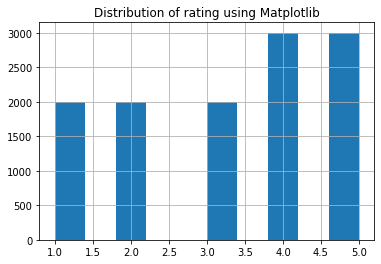

In [9]:
# PLotting Rating histogram

data.rating.hist()
plt.title("Distribution of rating using Matplotlib")
plt.show()

In [10]:
# PLotting Rating using ploty

fig = go.Figure([go.Bar(x=a.index, y=a.values,text=a.values)])
fig.update_layout(title='Distribution of the Rating using ploty')
fig.show()

# Preprocessing Data

- Dropping columns that are not needed

In [11]:
data.columns

Index(['Unnamed: 0', 'rating', 'reviewText', 'summary'], dtype='object')

In [12]:
data = data.drop(['Unnamed: 0', 'summary'], axis=1)

In [13]:
# preview of the dataset

data.head()

,rating,reviewText
0,5,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,5,I just had to edit this review. This book is a...
3,5,I don't normally buy 'mystery' novels because ...
4,5,"This isn't the kind of book I normally read, a..."


- converting rating to 0 and 1 from 1-5

In [14]:
# if rating is above 3 we will consider it as 1 else 0.

data["rating"] = data["rating"].apply(lambda x: 1 if x < 3  else 0) # positive as 0 and negative as 1
data

,rating,reviewText
0,0,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,0,I just had to edit this review. This book is a...
3,0,I don't normally buy 'mystery' novels because ...
4,0,"This isn't the kind of book I normally read, a..."
...,...,...
11995,1,Had to read certain passages twice--typos. Wi...
11996,0,Not what i expected. yet a very interesting bo...
11997,0,Dragon Knights is a world where Knights ride d...
11998,0,"Since this story is very short, it's hard to s..."


In [15]:
# lowering the text of the review

data["reviewText"] = data["reviewText"].str.lower()
data.head()

,rating,reviewText
0,0,this book was the very first bookmobile book i...
1,1,"when i read the description for this book, i c..."
2,0,i just had to edit this review. this book is a...
3,0,i don't normally buy 'mystery' novels because ...
4,0,"this isn't the kind of book i normally read, a..."


In [16]:
# removing punctuation

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

data["reviewText"] = data["reviewText"].apply(lambda text: remove_punctuation(text))
data.head()

,rating,reviewText
0,0,this book was the very first bookmobile book i...
1,1,when i read the description for this book i co...
2,0,i just had to edit this review this book is an...
3,0,i dont normally buy mystery novels because i j...
4,0,this isnt the kind of book i normally read alt...


In [17]:
#removing stop words from the dataset

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["reviewText"] = data["reviewText"].apply(lambda text: remove_stopwords(text))
data.head()

,rating,reviewText
0,0,book first bookmobile book bought school book ...
1,1,read description book couldnt wait read downlo...
2,0,edit review book believe got right updated rew...
3,0,dont normally buy mystery novels dont like how...
4,0,isnt kind book normally read although try limi...


In [18]:
lemmatizer = WordNetLemmatizer()
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

data["reviewText"] = data["reviewText"].apply(lambda text: lemmatize_words(text))
data.head()

,rating,reviewText
0,0,book first bookmobile book buy school book clu...
1,1,read description book couldnt wait read downlo...
2,0,edit review book believe get right update rewr...
3,0,dont normally buy mystery novels dont like how...
4,0,isnt kind book normally read although try limi...


# Visualization on Dataset

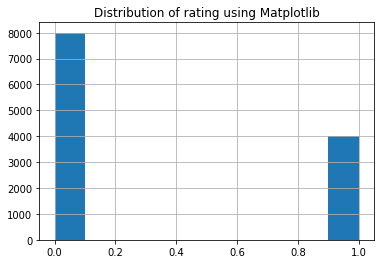

In [19]:
# PLotting Rating histogram

data.rating.hist()
plt.title("Distribution of rating using Matplotlib")
plt.show()

In [20]:
# PLotting Rating using ploty
a  = data.rating.value_counts()
fig = go.Figure([go.Bar(x=a.index, y=a.values,text=a.values)])
fig.update_layout(title='Distribution of the Rating using ploty')
fig.show()

- Plotting word cloud

In [21]:
text = " ".join(cat.split()[0] for cat in data.reviewText)
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

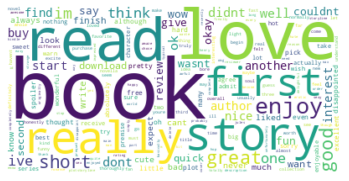

In [22]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [23]:
from collections import Counter
cnt = Counter()
for text in data["reviewText"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('book', 15397),
 ('story', 11027),
 ('read', 10023),
 ('like', 6207),
 ('one', 5949),
 ('character', 5677),
 ('get', 5453),
 ('love', 5059),
 ('good', 4763),
 ('would', 4093)]

In [24]:
cnt.get("book")

15397

In [25]:
cn = cnt.most_common(10)
w = []
c = []

In [26]:
for i in cn:
    w.append(i[0])
    c.append(i[1])

- Pie chart for Most Frequent Words

In [27]:
fig = px.pie(data, values=c, names=w, color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.update_layout(title="Most Frequent Words")
fig.show()

- Displaying Rarewords

In [28]:
n_rare_words = 11
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])

In [29]:
RAREWORDS

{'1922',
 'backgroung',
 'don8216t',
 'firedrake',
 'gryphon',
 'helos',
 'insite',
 'meaness',
 'relm',
 'symbols',
 'twicetypos'}

# Splitting the data

In [30]:
# preview of data

data

,rating,reviewText
0,0,book first bookmobile book buy school book clu...
1,1,read description book couldnt wait read downlo...
2,0,edit review book believe get right update rewr...
3,0,dont normally buy mystery novels dont like how...
4,0,isnt kind book normally read although try limi...
...,...,...
11995,1,read certain passage twicetypos wish build rel...
11996,0,expect yet interesting book usually don8216t r...
11997,0,dragon knight world knight ride dragon slay wi...
11998,0,since story short hard say much without give a...


In [31]:
train, test = train_test_split(data, test_size = 0.3, stratify = data['rating'], random_state = 42)

In [32]:
cv= CountVectorizer(binary=True, min_df = 10, max_df = 0.95)
cv.fit_transform(train['reviewText'].values)
train_feature_set=cv.transform(train['reviewText'].values)
test_feature_set=cv.transform(test['reviewText'].values)

In [33]:
train_feature_set

<8400x3773 sparse matrix of type '<class 'numpy.int64'>'
	with 322980 stored elements in Compressed Sparse Row format>

In [34]:
train_feature_set.shape[1]

3773

In [35]:
cv.vocabulary_['book']

422

In [36]:
y_train = train['rating'].values
y_test = test['rating'].values

# Building our Model

In [37]:
lr = LogisticRegression(random_state = 42, max_iter=1000)
lr.fit(train_feature_set,y_train)
y_pred = lr.predict(test_feature_set)
print("Accuracy: ",round(metrics.accuracy_score(y_test,y_pred),3))
print("F1: ",round(metrics.f1_score(y_test, y_pred),3))

Accuracy:  0.824
F1:  0.726


In [38]:
cm1 = confusion_matrix(y_test, y_pred)
cm1

array([[2126,  274],
       [ 360,  840]])

In [39]:
cm2 = confusion_matrix(y_test, y_pred,normalize='true')
cm2

array([[0.88583333, 0.11416667],
       [0.3       , 0.7       ]])

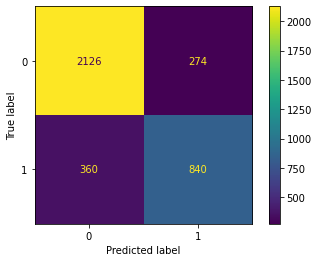

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm1,display_labels=lr.classes_)
disp.plot()
plt.show()

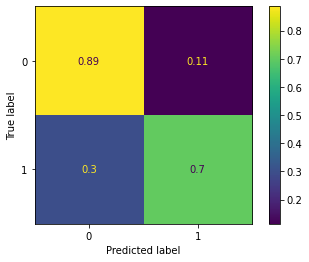

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm2,display_labels=lr.classes_)
disp.plot()
plt.show()

In [42]:
feature_importance = lr.coef_[0][:10]
for i,v in enumerate(feature_importance):
    print('Feature: ', list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(i)], 'Score: ', v)

Feature:  099 Score:  0.17009113456126124
Feature:  10 Score:  0.32618786733952304
Feature:  100 Score:  0.48837010936314723
Feature:  11 Score:  -0.38814976764855386
Feature:  12 Score:  -0.46210531282054784
Feature:  13 Score:  0.8430789988824341
Feature:  14 Score:  -0.6044090334662856
Feature:  15 Score:  0.9184474143072441
Feature:  16 Score:  0.4628201502148334
Feature:  17 Score:  0.41937803852545696


In [43]:
feature_importance = lr.coef_[0]
sorted_idx = np.argsort(feature_importance)

Top words for the positive class (negative sentiment):

In [44]:
top_10_pos_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[range(-1,-11, -1)]]
print(top_10_pos_w)

['waste', 'delete', 'cardboard', 'sorry', 'depress', 'boring', '25', 'thin', 'ugh', 'weird']


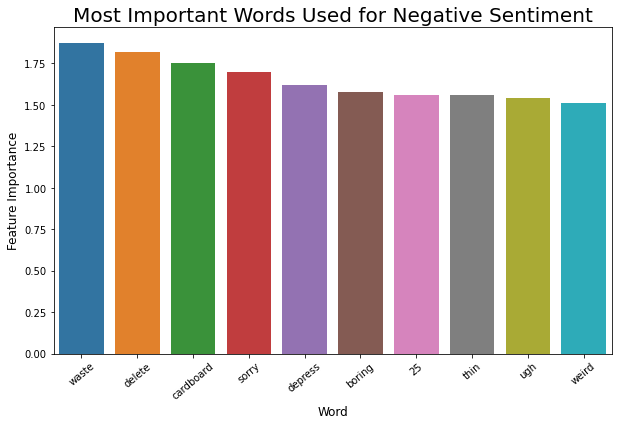

In [45]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_pos_w, y=feature_importance[sorted_idx[range(-1,-11, -1)]])
plt.title("Most Important Words Used for Negative Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

Top words for the negative class (positive sentiment):

In [46]:
top_10_neg_w = [list(cv.vocabulary_.keys())[list(cv.vocabulary_.values()).index(w)] for w in sorted_idx[:10]]
print(top_10_neg_w)

['enjoyed', 'verne', 'enjoyable', 'shot', 'fun', 'thumb', 'hunter', 'thrill', 'loved', 'hot']


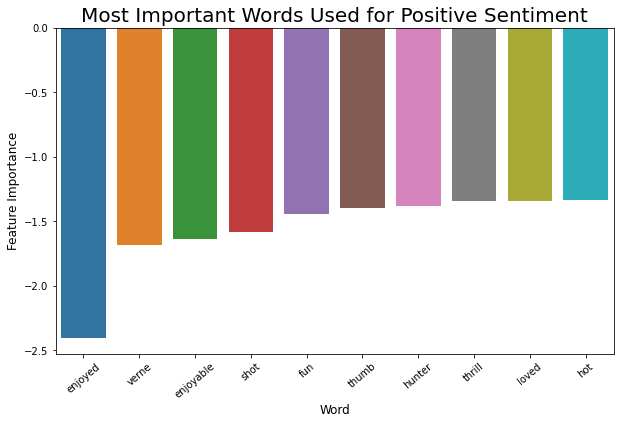

In [47]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x=top_10_neg_w, y=feature_importance[sorted_idx[:10]])
plt.title("Most Important Words Used for Positive Sentiment",fontsize = 20)
x_locs,x_labels = plt.xticks()
plt.setp(x_labels, rotation = 40)
plt.ylabel('Feature Importance', fontsize = 12)
plt.xlabel('Word', fontsize = 12);

# Prediction on our sentences

In [48]:
lr.classes_#negative class first, positive class next

array([0, 1])

In [49]:
test_review = cv.transform(["I did not enjoy the book"])
p = lr.predict_proba(test_review)
s = lr.predict(test_review)
print("prob are:",p)
print("prediction are:",s)

prob are: [[0.78784978 0.21215022]]
prediction are: [0]


- hyperparameter

In [50]:
pred_proba_df = pd.DataFrame(lr.predict_proba(test_feature_set))
threshold_list = [0.3,0.4,0.45,0.5]
for i in threshold_list:
    print ('\n******** For i = {} ******'.format(i))
    Y_test_pred = pred_proba_df.applymap(lambda x: 1 if x>i else 0)
    test_f1 = round(metrics.f1_score(y_test, Y_test_pred.loc[:,1].values),3)
    print('F1: {}'.format(test_f1))


******** For i = 0.3 ******
F1: 0.735

******** For i = 0.4 ******
F1: 0.733

******** For i = 0.45 ******
F1: 0.733

******** For i = 0.5 ******
F1: 0.726


# Recap: 
- We performed Sentiment Analysis on Amazon Kindle Review using Logistic Regression.
- We performed EDA.
- We performed Preprocessing steps for cleaning our dataset.
- Then we spilt our dataset into training and testing.
- We build our logistic regression model.
- Then we train our model with training dataset.
- We also evaulated our model using testing dataset and also used various evualation metrics.
- And then tried our own sentence to test our model.
- Then we plotted Most Important Words Used for Negative Sentiment as well as Most Important Words Used for Postive Sentiment



# [View my verious sentiment analysis notebook on the same topic](https://www.kaggle.com/code/meetnagadia/amazon-kindle-book-sentiment-analysis)

![](https://c.tenor.com/WGo9iYM9V2kAAAAC/the-end-background.gif)